# Development of the Tesla Stock Prediction Model

This notebook is only to show how the model was designed and evaluated. The predictions are generated using the prediction.py file.

## Import Libraries

Import the following necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Fetches, cleans, and saves Tesla stock data

Download historical stock data for Tesla from yahoo finance, clean it up by keeping only the most important columns, and save the resulting data as a CSV file. The process involves fetching daily price and volume information, converting the date index into a regular column, and then storing the cleaned data so that it can be easily accessed for analysis or modeling later on.

In [2]:
# Fetch Tesla stock data from Yahoo Finance and clean it properly
def fetch_tesla_data(start_date: str, end_date: str):
    
    print(f"Fetching Tesla stock data from {start_date} to {end_date}...")

    # Download stock data
    tesla_data = yf.download("TSLA", start=start_date, end=end_date, interval="1d")

    # Reset index to make 'Date' a column
    tesla_data.reset_index(inplace=True)

    # Keep only the necessary columns
    tesla_data = tesla_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

    # Save the cleaned data
    tesla_data.to_csv("tesla_stock_data.csv", index=False)

    print("Data saved as 'tesla_stock_data.csv'")
    return tesla_data

# Fetch and save the cleaned data
df = fetch_tesla_data("2015-01-01", "2025-03-22")  # Extend one day extra to avoid missing data
df

Fetching Tesla stock data from 2015-01-01 to 2025-03-22...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data saved as 'tesla_stock_data.csv'


Price,Date,Open,High,Low,Close,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500
...,...,...,...,...,...,...
2565,2025-03-17,245.059998,245.399994,232.800003,238.009995,111900600
2566,2025-03-18,228.160004,230.100006,222.279999,225.309998,111477600
2567,2025-03-19,231.610001,241.410004,229.199997,235.860001,111993800


## Visualizing Tesla's Closing Price History

We plot an overview of Tesla's closing price history over time, highlighting long-term trends. This allows us to see how the stock's value has evolved each year, helping to interpret the data and identify key trends in Tesla's market performance over the years.

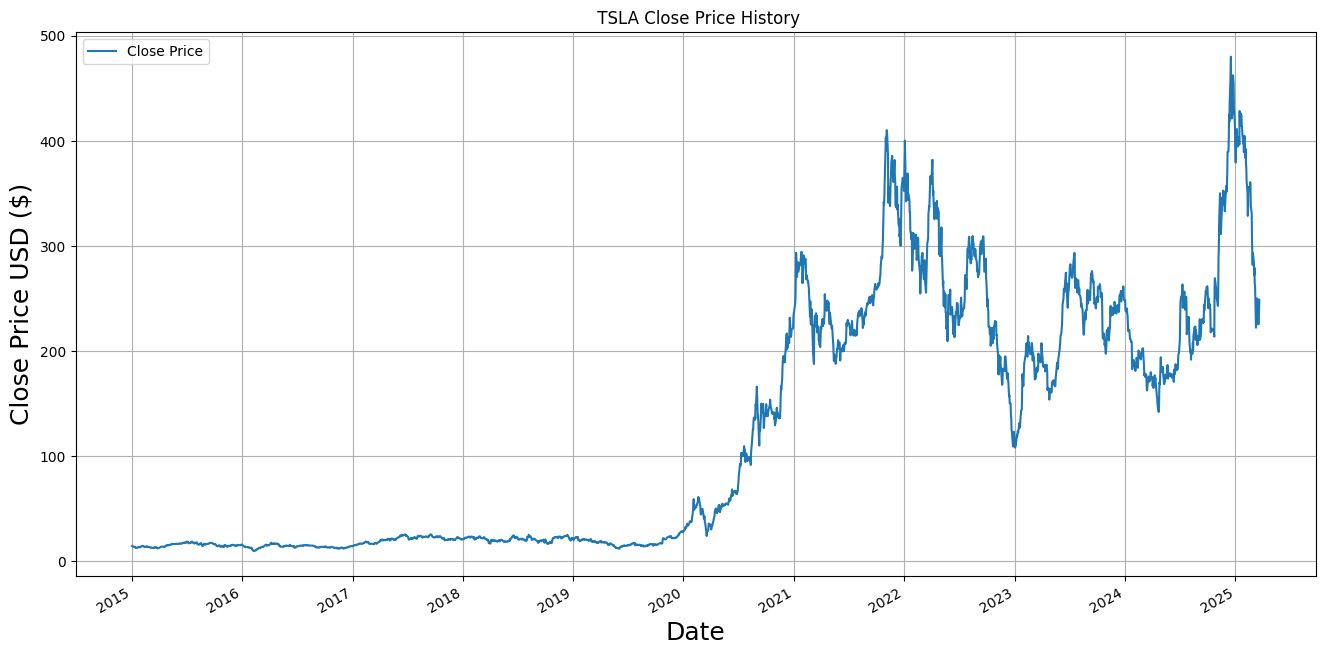

In [3]:
plt.figure(figsize=(16, 8))
plt.title(' TSLA Close Price History')

# Plot using Date as the x-axis, Close price as the y-axis
plt.plot(df['Date'], df['Close'], label='Close Price')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Get current Axes object and apply date formatting
ax = plt.gca()

# Place a major tick every year
ax.xaxis.set_major_locator(mdates.YearLocator())

# Format the ticks to show only the year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Automatically rotate date labels for better readability
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.show()


## Feature Engineering

In this feature engineering phase, the raw Tesla stock data is cleaned up and improved by creating features to use. This is done by calculating various technical indicators that help capture market dynamics more effectively.

To identify short-term trends, 5-day and 10-day Simple Moving Average are used. For mid-term trends, 20-day Simple Moving Average are used to smooth out daily price fluctuations. The 10-day Exponential Moving Average (EMA) is also calculated, placing more emphasis on recent price data to reflect more current market shifts. The Relative Strength Index (RSI), based on a 14-day period, provides insight into price momentum, highlighting conditions where the stock may be overbought or oversold.

To capture changes in momentum, the Moving Average Convergence Divergence (MACD) is included, showing how two moving averages relate to each other. A basic momentum indicator tracks the day-to-day change in closing prices, while daily returns are computed to represent the percentage change in price from one day to the next.

Volatility is measured as well, giving an idea of how much the price fluctuates. Additionally, the Average Directional Index (ADX) is calculated to assess the strength of a trend, regardless of its direction. After all these indicators are added, any new rows with missing data are removed, resulting in a clean, feature-rich dataset that's ready for deeper analysis and model training.

In [4]:
# Load the cleaned Tesla stock data from the CSV file
df = pd.read_csv("tesla_stock_data.csv")

# Convert the 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Convert price and volume columns to numeric data types
columns_to_convert = ["Open", "High", "Low", "Close", "Volume"]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove rows with missing values
df.dropna(inplace=True)

# Calculate technical indicators to be used as features
df["SMA_5"] = ta.trend.sma_indicator(df["Close"], window=5)
df["SMA_10"] = ta.trend.sma_indicator(df["Close"], window=10)
df["SMA_20"] = ta.trend.sma_indicator(df["Close"], window=20)
df["EMA_10"] = ta.trend.ema_indicator(df["Close"], window=10)
df["RSI_14"] = ta.momentum.rsi(df["Close"], window=14)
df["MACD"] = ta.trend.macd(df["Close"])
df["Momentum"] = df["Close"].diff()                     
df["Daily_Return"] = df["Close"].pct_change() * 100       
df["Volatility"] = df["Close"].rolling(10).std()          
df["ADX"] = ta.trend.adx(df["High"], df["Low"], df["Close"], window=14)  

# Drop any NaN values generated from rolling calculations
df.dropna(inplace=True)

# Display the first few rows of the processed dataset
df

,Date,Open,High,Low,Close,Volume,SMA_5,SMA_10,SMA_20,EMA_10,RSI_14,MACD,Momentum,Daily_Return,Volatility,ADX
26,2015-02-09,14.358667,14.528667,14.132667,14.498667,52086000.0,14.569867,14.118867,13.666267,14.210122,59.778755,0.132076,0.007999,0.055204,0.514550,0.000000
27,2015-02-10,14.503333,14.700000,14.333333,14.419333,80857500.0,14.542267,14.187600,13.713200,14.248161,57.924501,0.144198,-0.079333,-0.547177,0.502906,0.000000
28,2015-02-11,14.147333,14.316000,13.818667,14.186667,146536500.0,14.465600,14.277133,13.741700,14.236980,52.756090,0.133491,-0.232666,-1.613570,0.393386,22.059690
29,2015-02-12,12.904667,13.539333,12.885333,13.525333,234744000.0,14.224134,14.261667,13.775667,14.107590,41.438143,0.070826,-0.661334,-4.661659,0.421507,23.043954
30,2015-02-13,13.526667,13.732667,13.394000,13.584667,92865000.0,14.042934,14.262800,13.815333,14.012513,42.627373,0.025655,0.059334,0.438686,0.419461,23.510642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,2025-03-17,245.059998,245.399994,232.800003,238.009995,111900600.0,241.467996,250.675002,284.866499,254.384579,31.967596,-33.068790,-11.970001,-4.788384,18.428476,40.846132
2567,2025-03-18,228.160004,230.100006,222.279999,225.309998,111477600.0,240.413995,246.002000,278.426499,249.098292,29.570074,-33.348524,-12.699997,-5.335909,18.333421,41.798513
2568,2025-03-19,231.610001,241.410004,229.199997,235.860001,111993800.0,237.967996,241.678000,272.191499,246.691330,33.998410,-32.346053,10.550003,4.682439,14.319534,41.796849
2569,2025-03-20,233.350006,238.000000,230.050003,236.259995,99028300.0,237.083997,238.958998,266.284499,244.794723,34.167419,-31.160117,0.399994,0.169590,12.141966,41.795304


## Feature Visualization

The chart below illustrates the comparison between Tesla's historical closing stock prices and three of the features: the 5-Day, 10-Day and 20-Day Simple Moving Averages (SMAs). These moving averages help smooth out price fluctuations, making it easier to identify broader trends in the stock's movement. The 5-Day and 10-Day SMA represents a shorter-term trend, while the 20-Day SMA captures a more medium-term view. We look at short and medium term trends as we are predicting the next 5 days. This visualization is important because it allows traders to observe how the stock price interacts with its moving averages. Furthermore, by filtering out the daily price noise, SMAs provide a clearer picture of any trends, helping investors make more informed decisions.

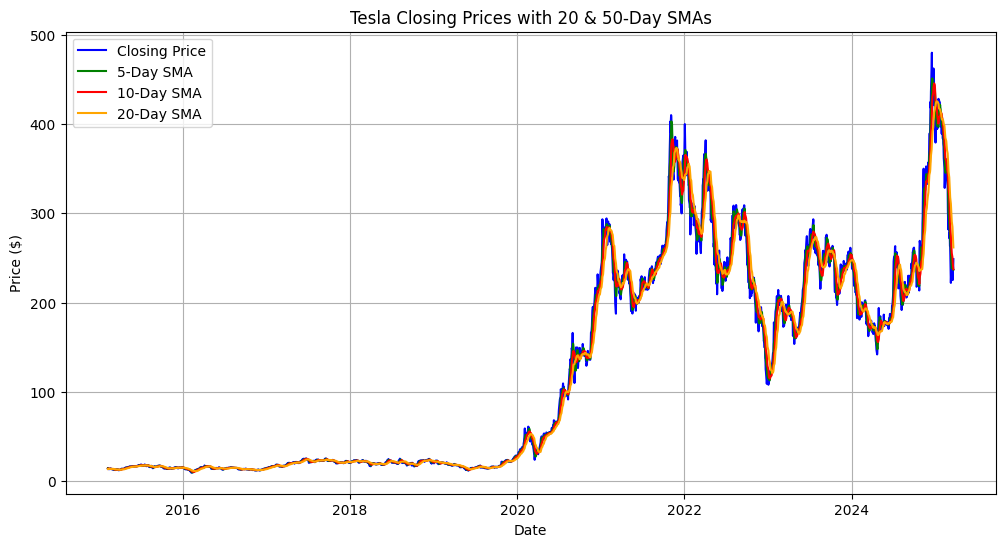

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label="Closing Price", color='blue')
plt.plot(df['Date'], df['SMA_5'], label="5-Day SMA", color='green')
plt.plot(df['Date'], df['SMA_10'], label="10-Day SMA", color='red')
plt.plot(df['Date'], df['SMA_20'], label="20-Day SMA", color='orange')
plt.title("Tesla Closing Prices with 20 & 50-Day SMAs")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

The next chart below shows Tesla's 10-Day Rolling Volatility, which measures how much the stock price fluctuates over time. It helps identify periods of higher market risk and uncertainty, with spikes showing increased price swings that are usually the result of news or market events. Lower volatility would mean more stable price behavior. It is important to understand volatility for assessing risk and guiding trading decisions.

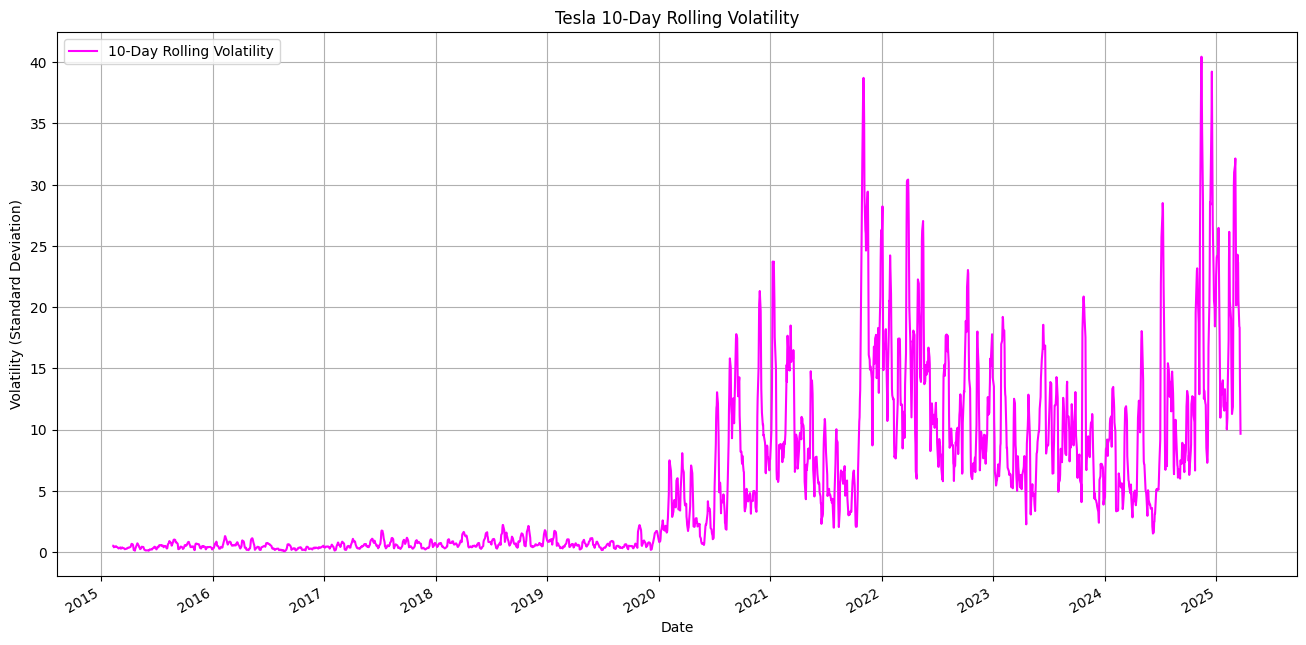

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['Volatility'], label='10-Day Rolling Volatility', color='magenta')
plt.title("Tesla 10-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (Standard Deviation)")
plt.legend()
plt.grid(True)

# Format the x-axis to display years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.show()



## Preparing Features and Target Variable for Stock Price Prediction

The dataset is prepared for training a predictive model to estimate Tesla's next-day closing price.

In [7]:
# Define the target variable, which is next day's closing price
df['Target_Price'] = df['Close'].shift(-1)
# Use linear interpolation to fill the last missing value
df['Target_Price'] = df['Target_Price'].interpolate(method='linear')

# List all the features to use
features = [
    "SMA_5",
    "SMA_10",
    "SMA_20", 
    "EMA_10", 
    "RSI_14", 
    "MACD", 
    "Momentum", 
    "Daily_Return", 
    "Volatility", 
    "ADX"
]

# Select features (X) and target variable (y)
X = df[features]
y = df['Target_Price']

# Perform a time-based train-test split (first 80% for training, last 20% for testing)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

df

Training set shape: (2036, 10) (2036,)
Testing set shape: (509, 10) (509,)


,Date,Open,High,Low,Close,Volume,SMA_5,SMA_10,SMA_20,EMA_10,RSI_14,MACD,Momentum,Daily_Return,Volatility,ADX,Target_Price
26,2015-02-09,14.358667,14.528667,14.132667,14.498667,52086000.0,14.569867,14.118867,13.666267,14.210122,59.778755,0.132076,0.007999,0.055204,0.514550,0.000000,14.419333
27,2015-02-10,14.503333,14.700000,14.333333,14.419333,80857500.0,14.542267,14.187600,13.713200,14.248161,57.924501,0.144198,-0.079333,-0.547177,0.502906,0.000000,14.186667
28,2015-02-11,14.147333,14.316000,13.818667,14.186667,146536500.0,14.465600,14.277133,13.741700,14.236980,52.756090,0.133491,-0.232666,-1.613570,0.393386,22.059690,13.525333
29,2015-02-12,12.904667,13.539333,12.885333,13.525333,234744000.0,14.224134,14.261667,13.775667,14.107590,41.438143,0.070826,-0.661334,-4.661659,0.421507,23.043954,13.584667
30,2015-02-13,13.526667,13.732667,13.394000,13.584667,92865000.0,14.042934,14.262800,13.815333,14.012513,42.627373,0.025655,0.059334,0.438686,0.419461,23.510642,13.623333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,2025-03-17,245.059998,245.399994,232.800003,238.009995,111900600.0,241.467996,250.675002,284.866499,254.384579,31.967596,-33.068790,-11.970001,-4.788384,18.428476,40.846132,225.309998
2567,2025-03-18,228.160004,230.100006,222.279999,225.309998,111477600.0,240.413995,246.002000,278.426499,249.098292,29.570074,-33.348524,-12.699997,-5.335909,18.333421,41.798513,235.860001
2568,2025-03-19,231.610001,241.410004,229.199997,235.860001,111993800.0,237.967996,241.678000,272.191499,246.691330,33.998410,-32.346053,10.550003,4.682439,14.319534,41.796849,236.259995
2569,2025-03-20,233.350006,238.000000,230.050003,236.259995,99028300.0,237.083997,238.958998,266.284499,244.794723,34.167419,-31.160117,0.399994,0.169590,12.141966,41.795304,248.710007


## Building and Training a Linear Regression Model with Feature Scaling

A model is trained to predict Tesla’s next-day closing price using the created features.

In [8]:
# Create a pipeline with scaling and a regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

## Model testing and Visualizing Predictions

The trained linear regression model is used to make predictions on the test set, estimating Tesla’s next-day closing prices based on the features. We use Mean Absolute Error (MAE) and Mean Squared Error (MSE) to measure how close the predicted prices are to the actual values.

In [9]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Mean Absolute Error: 6.90
Mean Squared Error: 97.38


To visually evaluate the results, a plot is generated comparing the actual vs. predicted prices on the test set over time. This allows for a good understanding of how well the model tracks the real price movements. We can see that the model is actually performing really well, predicting the trends very closely.

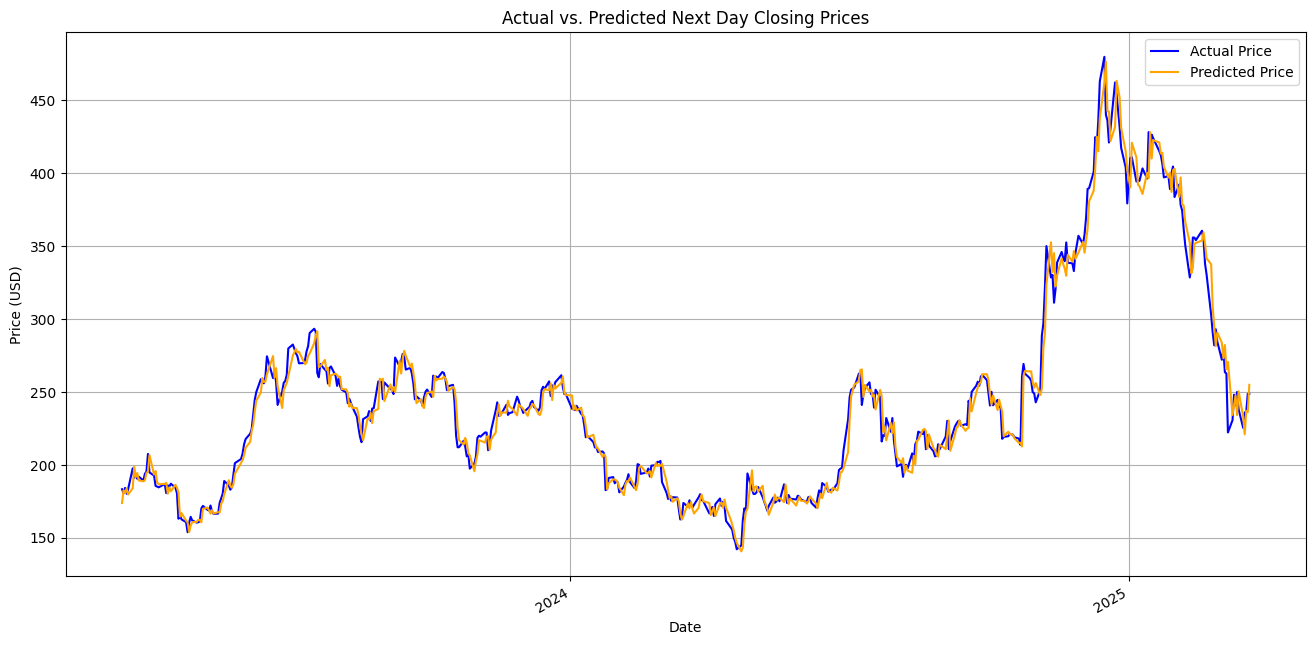

In [10]:
# Plot actual vs predicted prices
plt.figure(figsize=(16, 8))
plt.plot(df['Date'].iloc[split_index:], y_test, label="Actual Price", color='blue')
plt.plot(df['Date'].iloc[split_index:], y_pred, label="Predicted Price", color='orange')
plt.title("Actual vs. Predicted Next Day Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()
